In [1]:
#Setup

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os
import tarfile
import urllib

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#set seed
np.random.seed(42)

In [2]:
#Get Github Data

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
#Execute functions to get data

fetch_housing_data()

housing = load_housing_data()

In [4]:
#Total Bedrooms has fewer non-null data than the rest - problem! (.info() works too)
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


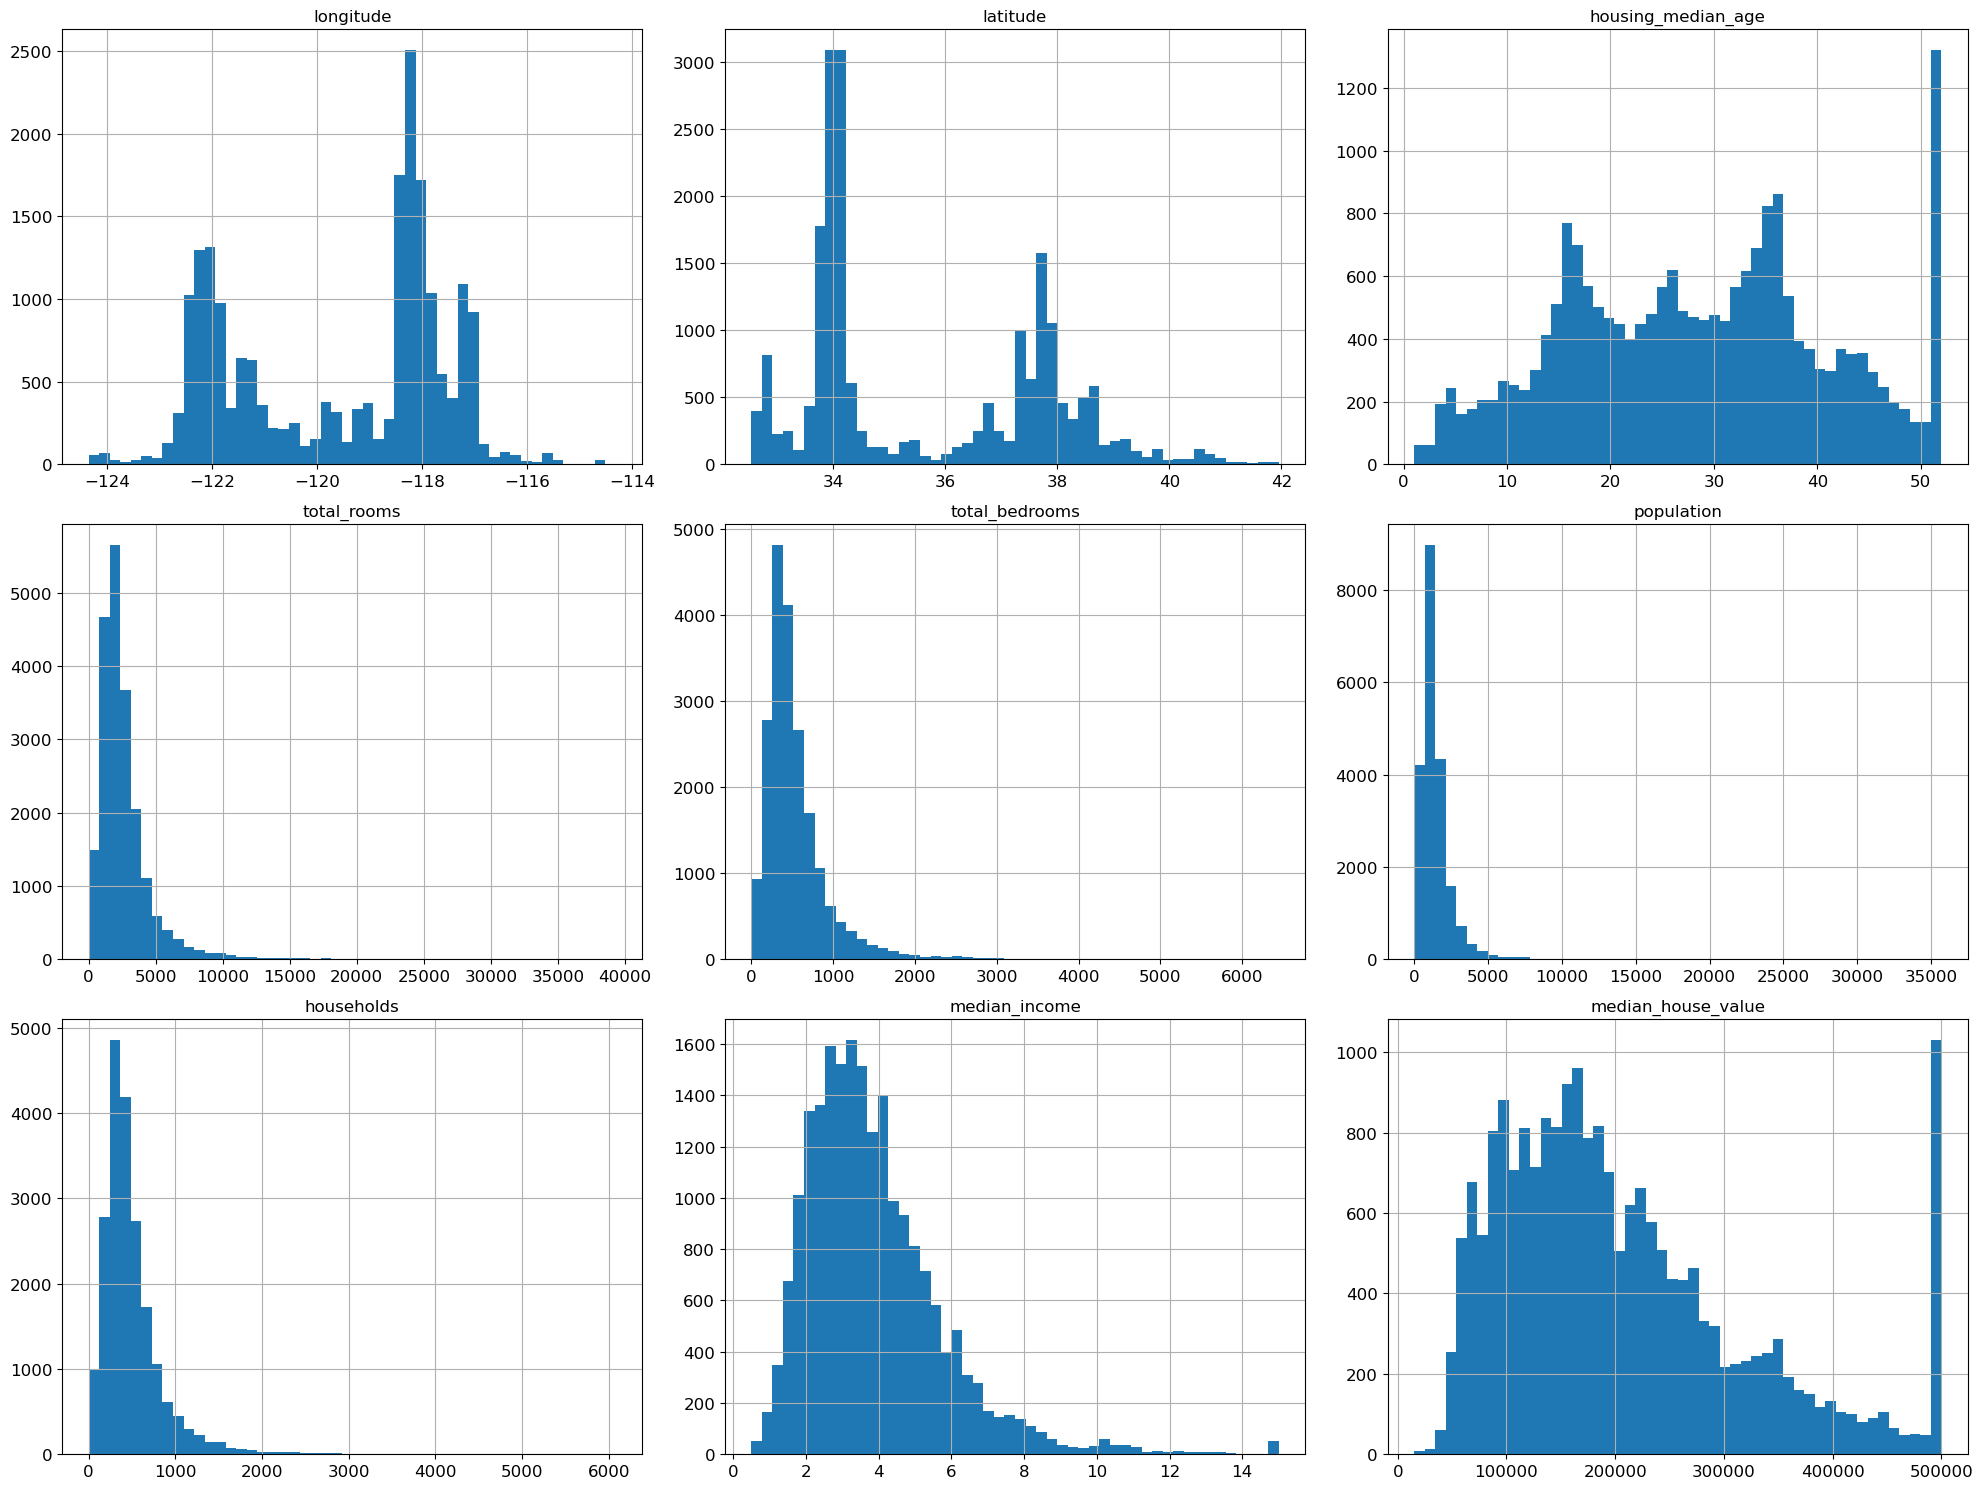

In [5]:
#Graphical analysis/diagnosis

housing.hist(bins=50, figsize=(20,15)) #Bins just to make data look better
save_fig("attribute_histogram_plots")
plt.show()

#Conclusions from weird tail-heavy/tail-spiking distributions:
# -housing_median_age is top-coded at 52
# -median_house_value is top-coded at 500000
# -median_income is topcoded at 15

#also, total_bedrooms has nulls

In [6]:
#along with train_test_split, we use stratified sampling due to skew in the population, which if sampled regularly will show bias

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

<AxesSubplot:>

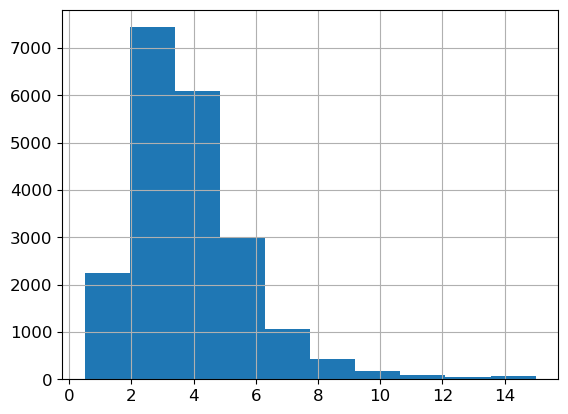

In [7]:
housing["median_income"].hist()
#Since median housing is around $2000-5000, with long right tail.

<AxesSubplot:>

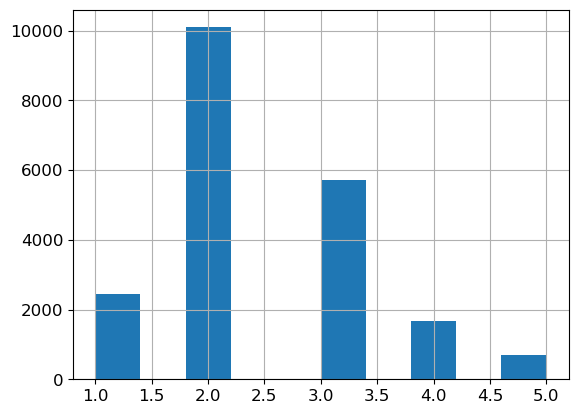

In [8]:
# Divide by 2 to limit the number of income categories (strata). Ceiling rounds up the numbers
housing["income_cat"] = np.ceil(housing["median_income"] / 2)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # Label those above 5 as 5 - remove top-coded vals

# Income transformation
housing["income_cat"].hist()

In [9]:
#Now onto stratified sampling

# Code a commande split: 80/20 with a single split with random state 42
stratsplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Create two datasets by splitting the housing data stratified by housing["income_cat"]
for train_index, test_index in stratsplit.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
# Find category proportions and see how random sampling vs stratified sampling differs

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    # Overall sample
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
    }).sort_index()

#deviation from strat sampling and regular sampling in percentages  
compare_props["Rand. %error"] =  100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [11]:
#t-test to check that the means of stratified sampling and regular sampling are different, grouped by income_cat

import scipy.stats as stats

tstat = []
p_val = []
decision = []
for cat in list(range(1,len(pd.unique(strat_test_set["income_cat"]))+1)):
    ttest = stats.ttest_ind(a=strat_test_set[strat_test_set["income_cat"]==cat]["median_income"],
                        b=test_set[test_set["income_cat"]==cat]["median_income"],
                        equal_var=True)
    tstat.append(ttest[0])
    p_val.append(ttest[1])
    #t-test - null: same means; alternate: different means 
    if ttest[1]<0.05:
        decision.append("yes")
    else:
        decision.append("no")
compare_props["tstat"] = tstat
compare_props["p_val"] = p_val
compare_props["different at 95%"] = decision 

In [12]:
compare_props

#so maybe it doesn't really matter whether it's stratified?

,Overall,Stratified,Random,Rand. %error,Strat. %error,tstat,p_val,different at 95%
1.0,0.119041,0.119186,0.120882,1.546602,0.122100,1.312389,0.189693,no
2.0,0.489147,0.489099,0.500484,2.317750,-0.009905,-1.458654,0.144737,no
3.0,0.277374,0.277374,0.269138,-2.969432,0.000000,0.880368,0.378754,no
4.0,0.081008,0.080911,0.076793,-5.203349,-0.119617,0.617774,0.536941,no
5.0,0.033430,0.033430,0.032703,-2.173913,0.000000,0.017953,0.985689,no


In [13]:
# Next we drop the income_cat to return the data to the original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [14]:
# We create a reference to the strat_train_set. If we change strat_train_set then the housing data will change as well
housing2 = strat_train_set.copy()

Saving figure cali_plot


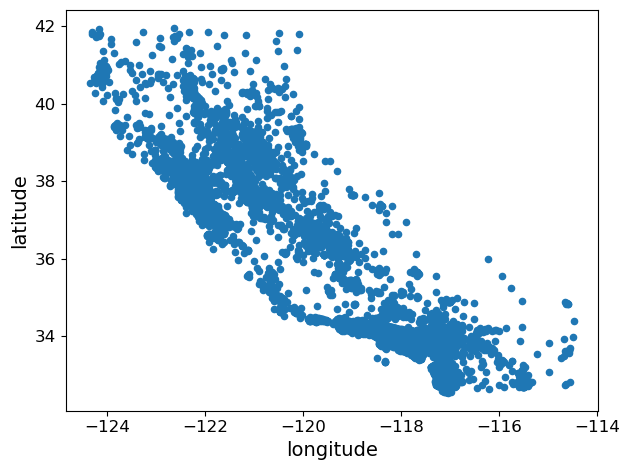

In [15]:
# plot location data of housing data
housing2.plot(kind="scatter", x="longitude", y="latitude")
save_fig("cali_plot")

Saving figure cali_density


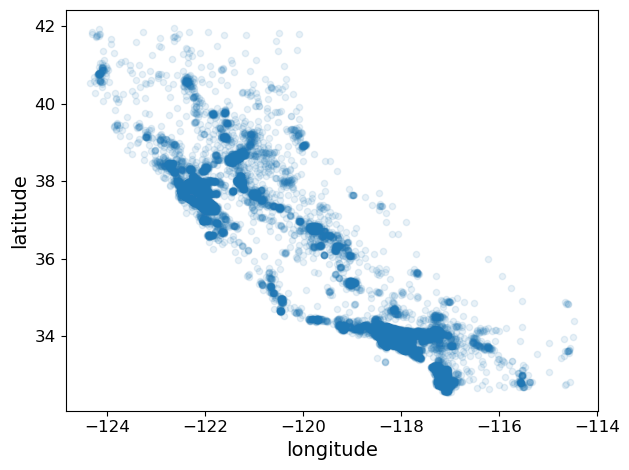

In [16]:
# Parameter alpha is the transparency of the dots, which we alter to see density.
housing2.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("cali_density")

Saving figure housing_prices_scatterplot


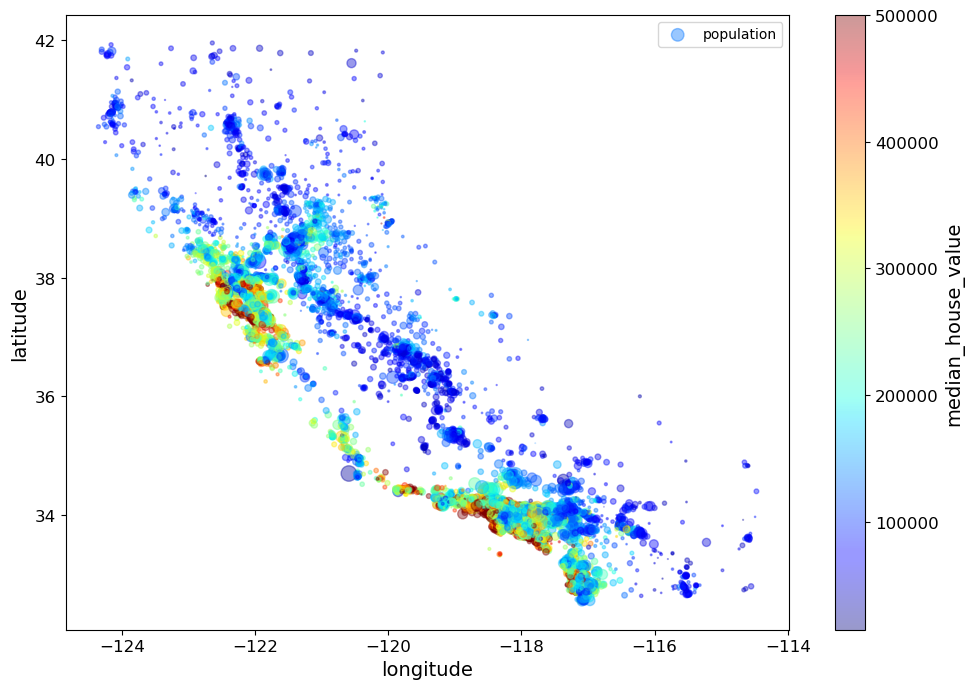

In [18]:
#Introduce color

housing2.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing2["population"]/100,
    label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

# Size (s) of the dot is population/100, color (c) is the housing value, "jet" colormap shows colors from red to blue.
# We don't know where anything is though...

In [19]:
# ...so let's download a California map
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(filename))

('california.png', <http.client.HTTPMessage at 0x1c0605e7f10>)

Saving figure california_housing_prices_plot


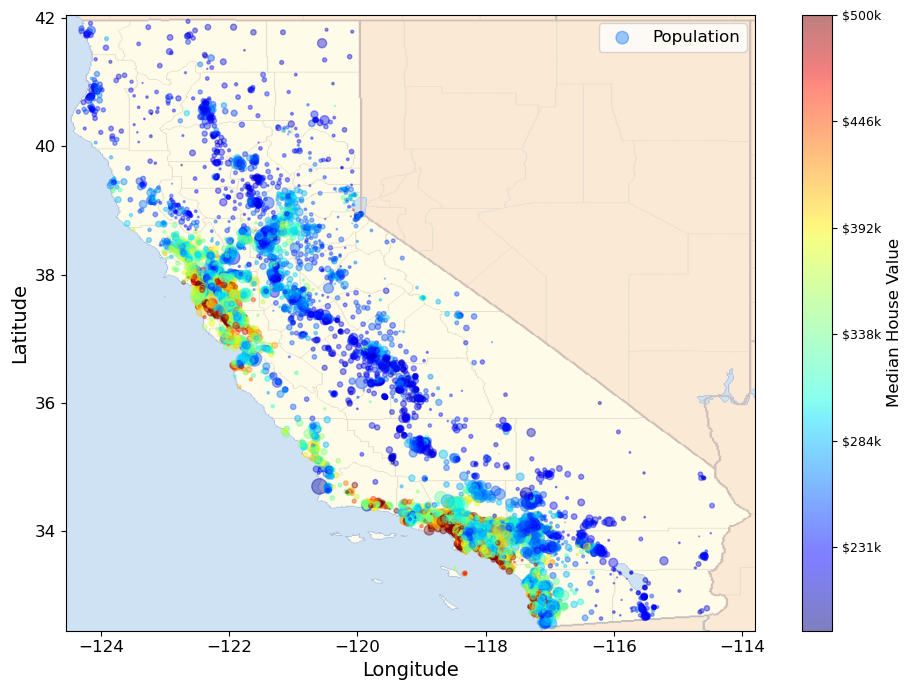

In [20]:
import matplotlib.image as mpimg

# base plot
california_img=mpimg.imread(filename)
ax = housing2.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing2['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,)
# show part of the map (extent) with 0.5 transparency
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# deal with legends and labels
prices = housing2["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 10) #arbitrary number to reduce number of legend ticks (500k, 446k etc)
cbar = plt.colorbar(ticks=tick_values/prices.max()) #ticks as a "proportion" of max
cbar.ax.set_yticklabels([F"${round(v/1000)}k" for v in tick_values], fontsize=9) #simplify colorbar legend with F-string
cbar.set_label('Median House Value', fontsize=12)

plt.legend(fontsize=12)
save_fig("california_housing_prices_plot")
plt.show()

In [21]:
# Another visualization/diagnosis technique - correlation plots

corr_matrix = housing2.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688863
total_rooms           0.132373
housing_median_age    0.110525
households            0.062793
total_bedrooms        0.046086
population           -0.028369
longitude            -0.045430
latitude             -0.143982
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


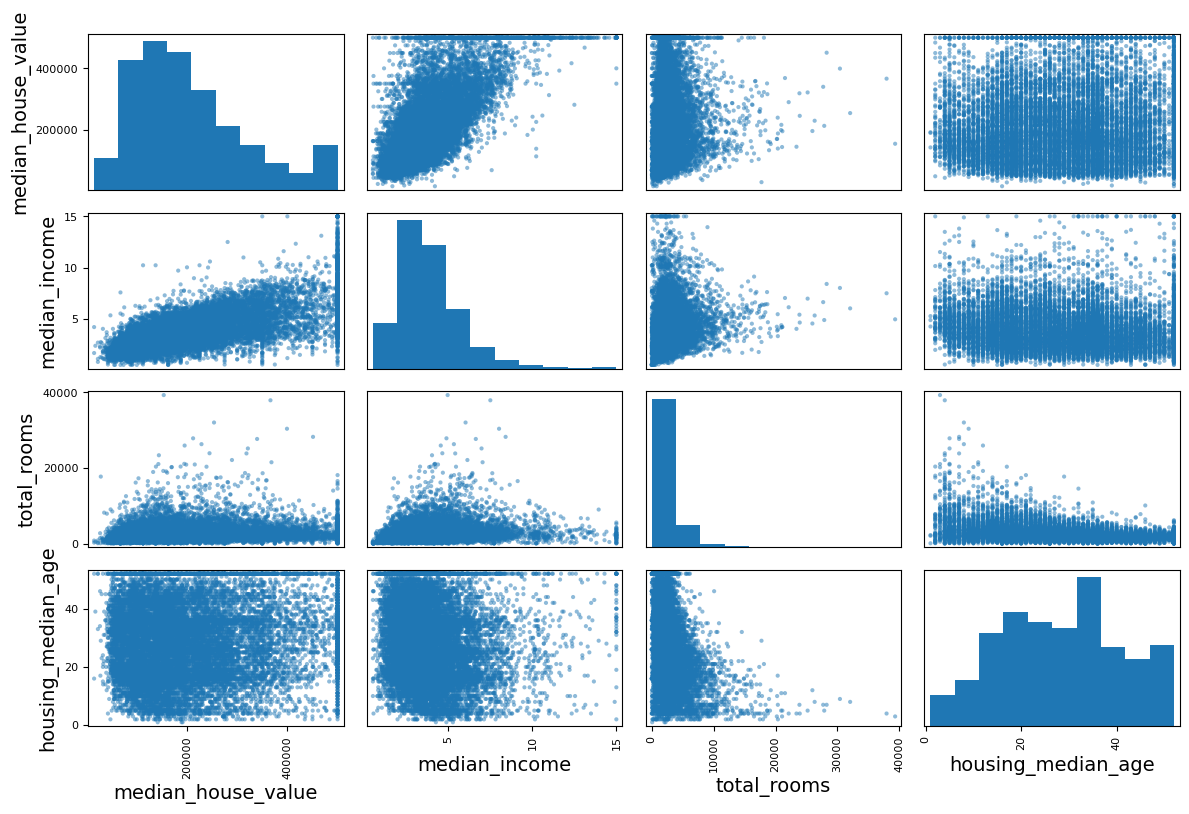

In [22]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing2[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

# only median_income and median_house_value have some relationship...others look weak

Saving figure income_vs_house_value_scatterplot


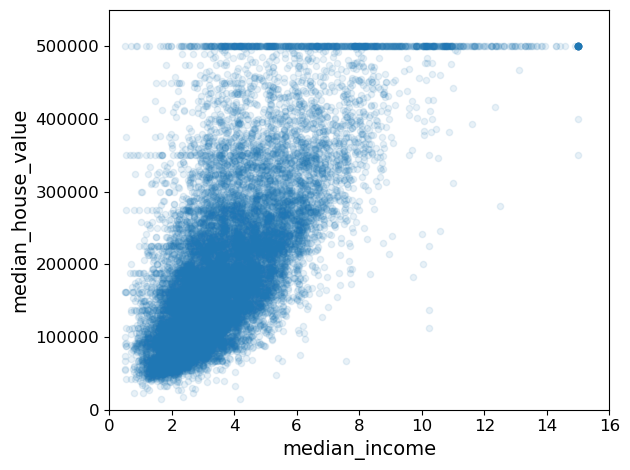

In [23]:
housing2.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [24]:
# Some attributes have a tail-heavy distribution, so we will transform them (e.g., by computing their logarithm).

# We try out various attribute combinations. For example, the total number of rooms in a district is not very
# useful if you don’t know how many households there are. What you really want is the number of rooms
# per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to
# compare it to the number of rooms. And the population per household


housing2["rooms_per_household"] = housing2["total_rooms"]/housing2["households"]
housing2["bedroom-room_ratio"] = housing2["total_bedrooms"]/housing2["total_rooms"]
housing2["population_per_household"]=housing2["population"]/housing2["households"]

In [25]:
corr_matrix = housing2.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688863
rooms_per_household         0.144402
total_rooms                 0.132373
housing_median_age          0.110525
households                  0.062793
total_bedrooms              0.046086
population_per_household   -0.022513
population                 -0.028369
longitude                  -0.045430
latitude                   -0.143982
bedroom-room_ratio         -0.258878
Name: median_house_value, dtype: float64

In [26]:
# "Label" = dependent variable aka y; "Features" = indep var

# It does not affect the training set, we just created a copy
housing2 = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set - we only want the x's
# create separate label vector
housing2_labels = strat_train_set["median_house_value"].copy()

In [27]:
#see how many rows have NaN's - 158 rows!

sample_incomplete_rows = housing2[housing2.isnull().any(axis=1)]
sample_incomplete_rows.shape

(167, 9)

In [28]:
# Use SciKit Imputer

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [29]:
housing2_num = housing2.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [30]:
imputer.fit(housing2_num)
# Imputer values. # imputer is the estimator.
X = imputer.transform(housing2_num)

In [32]:
# create Pandas file out of matrix created by the Imputer
housing2_tr = pd.DataFrame(X, columns=housing2_num.columns,
                          index = list(housing2.index.values))

In [33]:
# Look at imputed observations , total_bedrooms = NaN are now total_bedrooms = 436
housing2_tr.loc[sample_incomplete_rows.index.values].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
19071,-122.53,38.32,22.0,3577.0,436.0,1371.0,501.0,5.7950
7763,-118.10,33.91,36.0,726.0,436.0,490.0,130.0,3.6389
4629,-118.30,34.07,18.0,3759.0,436.0,3296.0,1462.0,2.2708
19332,-122.91,38.46,18.0,2021.0,436.0,912.0,329.0,4.5000
15663,-122.44,37.80,52.0,3830.0,436.0,1310.0,963.0,3.4801


In [34]:
#Time to process the categorical vars

housing2_cat = housing2[['ocean_proximity']]

In [36]:
#create a dummy for each categorical variable

from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(drop='first') #DROP ONE DUMMY TO PREVENT DUMMY VAR TRAP i.e. PERF. MULTICOL
housing2_cat_1hot = cat_encoder.fit_transform(housing2_cat)
housing2_cat_1hot

<16512x4 sparse matrix of type '<class 'numpy.float64'>'
	with 9226 stored elements in Compressed Sparse Row format>

In [37]:
housing2_cat_1hot.toarray()

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [38]:
cat_encoder = OneHotEncoder(drop='first', sparse=False)
housing2_cat_1hot = cat_encoder.fit_transform(housing2_cat)
housing2_cat_1hot

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

In [40]:
housing2_cat

,ocean_proximity
249,NEAR BAY
2355,INLAND
11234,<1H OCEAN
14455,NEAR OCEAN
19071,<1H OCEAN
...,...
20474,<1H OCEAN
13975,INLAND
8907,<1H OCEAN
16805,NEAR OCEAN
